In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import time

In [2]:
dataFul=np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')
dataFul[:,1:]=dataFul[:,1:]/255

def makeDataSet(Num,doubleData=False):
    
    data=dataFul[:Num,1:]
    label=dataFul[:Num,0]
    
    if doubleData:
        dataNoise=data+np.random.random_sample(data.shape)/2
        data=np.concatenate((data,dataNoise),axis=0)
        
        label=np.concatenate((label,label),axis=0)
        
    datatensor=torch.tensor(data).float()
    labeltensor=torch.tensor(label).long()
    
    train_data,devset_data,train_label,devset_label=train_test_split(\
                                                datatensor,labeltensor,train_size=0.9)
    
    
    train_dataset=TensorDataset(train_data,train_label)
    devset_dataset=TensorDataset(devset_data,devset_label)
    
    output={}
    
    output['train_loader']=DataLoader(train_dataset,batch_size=32,shuffle=True,drop_last=True)
    output['devset_loader']=DataLoader(devset_dataset,batch_size=devset_dataset.tensors[0].shape[0])
    
    
    output['test_data']=torch.tensor(dataFul[Num:,1:]).float()
    output['test_label']=torch.tensor(dataFul[Num:,0]).long()
    
    return output  

In [190]:
dataFul=np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')
dataFul[:,1:]=dataFul[:,1:]/255

def makeDataSet_2(Num,doubleData=False):  #change pixel value: if it is 1,then to zero. and reversely.
    
    data=dataFul[:Num,1:]
    label=dataFul[:Num,0]
    
    if doubleData:
        pix=np.where(data[:]>0)
        zeropix=np.where(data[:]==0)
        
        dataNoise=data
        
        dataNoise[pix[0],pix[1]]=0
        dataNoise[zeropix[0],zeropix[1]]=1
                
        data=np.concatenate((data,dataNoise),axis=0)
        label=np.concatenate((label,label),axis=0)
        
    datatensor=torch.tensor(data).float()
    labeltensor=torch.tensor(label).long()
    
    train_data,devset_data,train_label,devset_label=train_test_split(\
                                                datatensor,labeltensor,train_size=0.9)
    
    
    train_dataset=TensorDataset(train_data,train_label)
    devset_dataset=TensorDataset(devset_data,devset_label)
    
    output={}
    
    output['train_loader']=DataLoader(train_dataset,batch_size=4,shuffle=True,drop_last=False)
    output['devset_loader']=DataLoader(devset_dataset,batch_size=devset_dataset.tensors[0].shape[0])
    
    
    output['test_data']=torch.tensor(dataFul[Num:,1:]).float()
    output['test_label']=torch.tensor(dataFul[Num:,0]).long()
    
    return output  

In [64]:
def createModel():
    
    class model(nn.Module):
        def __init__(self):
            super().__init__()
            self.input=nn.Linear(784,32)
            
            self.fc1=nn.Linear(32,64)
            self.fc2=nn.Linear(64,64)
            
            self.output=nn.Linear(64,10)
            
        def forward(self,x):
            x=F.leaky_relu(self.input(x))
            
            x=F.leaky_relu(self.fc1(x))
            x=F.leaky_relu(self.fc2(x))
            
            return self.output(x)
        
    ann=model()
    
    lossfun=nn.CrossEntropyLoss()
    
    optimizer=torch.optim.SGD(ann.parameters(),lr=0.01)
    
    return ann,lossfun,optimizer            

In [55]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

def trainModelwithGpu(dataset,Numepoch=100):
    
    train_loader=dataset['train_loader']
    devset_loader=dataset['devset_loader']
    
    #train and test accuracies over each epoch
    trainAcc=[]
    devsetAcc=[]
    losses=torch.zeros(Numepoch)
    
    #the time spended training process
    processTime=time.process_time()
       
    #create new ann model
    ANN,lossfun,optimizer=createModel()
    
    ANN.to(device)
    
    for epoch in range(Numepoch):
        # time
        startTime=time.process_time()
        
        #accuracy and loss over one epoch
        batchAcc=[]
        batchLoss=[]
        
        ANN.train()
        
        for dat,lab in train_loader:
            
            dat=dat.to(device)
            lab=lab.to(device)
            
            yHat=ANN(dat)
            loss=lossfun(yHat,lab)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            yHat=yHat.cpu()
            lab=lab.cpu()
            
            match= (torch.argmax(yHat,axis=1)==lab).float()
            batchAcc.append(100*torch.mean(match))
            
            
        
        trainAcc.append(np.mean(batchAcc))
        losses[epoch]=np.mean(batchLoss)

        ANN.eval()
        dat,lab=next(iter(devset_loader))
        
        dat=dat.to(device)
        lab=lab.to(device)
            
        with torch.no_grad():
            yHat=ANN(dat)
        
        yHat=yHat.cpu()
        lab=lab.cpu()
        
        match= (torch.argmax(yHat,axis=1)==lab).float()
        devsetAcc.append(100*torch.mean(match))
        
        completedTime=time.process_time()-startTime
        
#         print(f'{epoch+1}-th trainAcc:{trainAcc[epoch]},----testAcc{testAcc[epoch]},----lossValue:{losses[epoch]},---CompTime {completedTime:.2f}-sec')
        
    processTime=time.process_time()-processTime  

    return ANN,trainAcc,devsetAcc,losses,processTime

cuda:0


In [199]:
sampleSize=np.arange(300,3801,500)

resultsSingleData=np.zeros((len(sampleSize),4))
resultsDoubleData=np.zeros((len(sampleSize),4))

for idx,datasize in enumerate(sampleSize):
    
    dataset=makeDataSet_2(datasize)
    ANN,trainAcc,devsetAcc,losses,processTime=trainModelwithGpu(dataset,50)
    
    resultsSingleData[idx,0]=np.mean(trainAcc[-5:])
    resultsSingleData[idx,1]=np.mean(devsetAcc[-5:])
    resultsSingleData[idx,2]=torch.mean(losses[-5:]).item()
    
    test_data=dataset['test_data'].to(device)
    test_label=dataset['test_label'].to(device)
    
    prediction=ANN(test_data)
    
    prediction.cpu()
    test_label.cpu()
    
    match=((torch.argmax(prediction,axis=1)==test_label).float())
    
    
    testAcc=100*torch.mean(match)
    resultsSingleData[idx,3]=testAcc 

    
    dataset=makeDataSet_2(datasize,True)
    ANN,trainAcc,devsetAcc,losses,processTime=trainModelwithGpu(dataset,50)
    
    resultsDoubleData[idx,0]=np.mean(trainAcc[-5:])
    resultsDoubleData[idx,1]=np.mean(devsetAcc[-5:])
    resultsDoubleData[idx,2]=torch.mean(losses[-5:]).item()
    
    test_data=dataset['test_data'].to(device)
    test_label=dataset['test_label'].to(device)
    
    prediction=ANN(test_data)
    
    prediction.cpu()
    test_label.cpu()
    
    match=((torch.argmax(prediction,axis=1)==test_label).float()).cpu() 

    
    testAcc=100*torch.mean(match)
    resultsDoubleData[idx,3]=testAcc 

(300, 784)
(600, 784)
(800, 784)
(1600, 784)
(1300, 784)
(2600, 784)
(1800, 784)
(3600, 784)
(2300, 784)
(4600, 784)
(2800, 784)
(5600, 784)
(3300, 784)
(6600, 784)
(3800, 784)
(7600, 784)


0
1
2
3


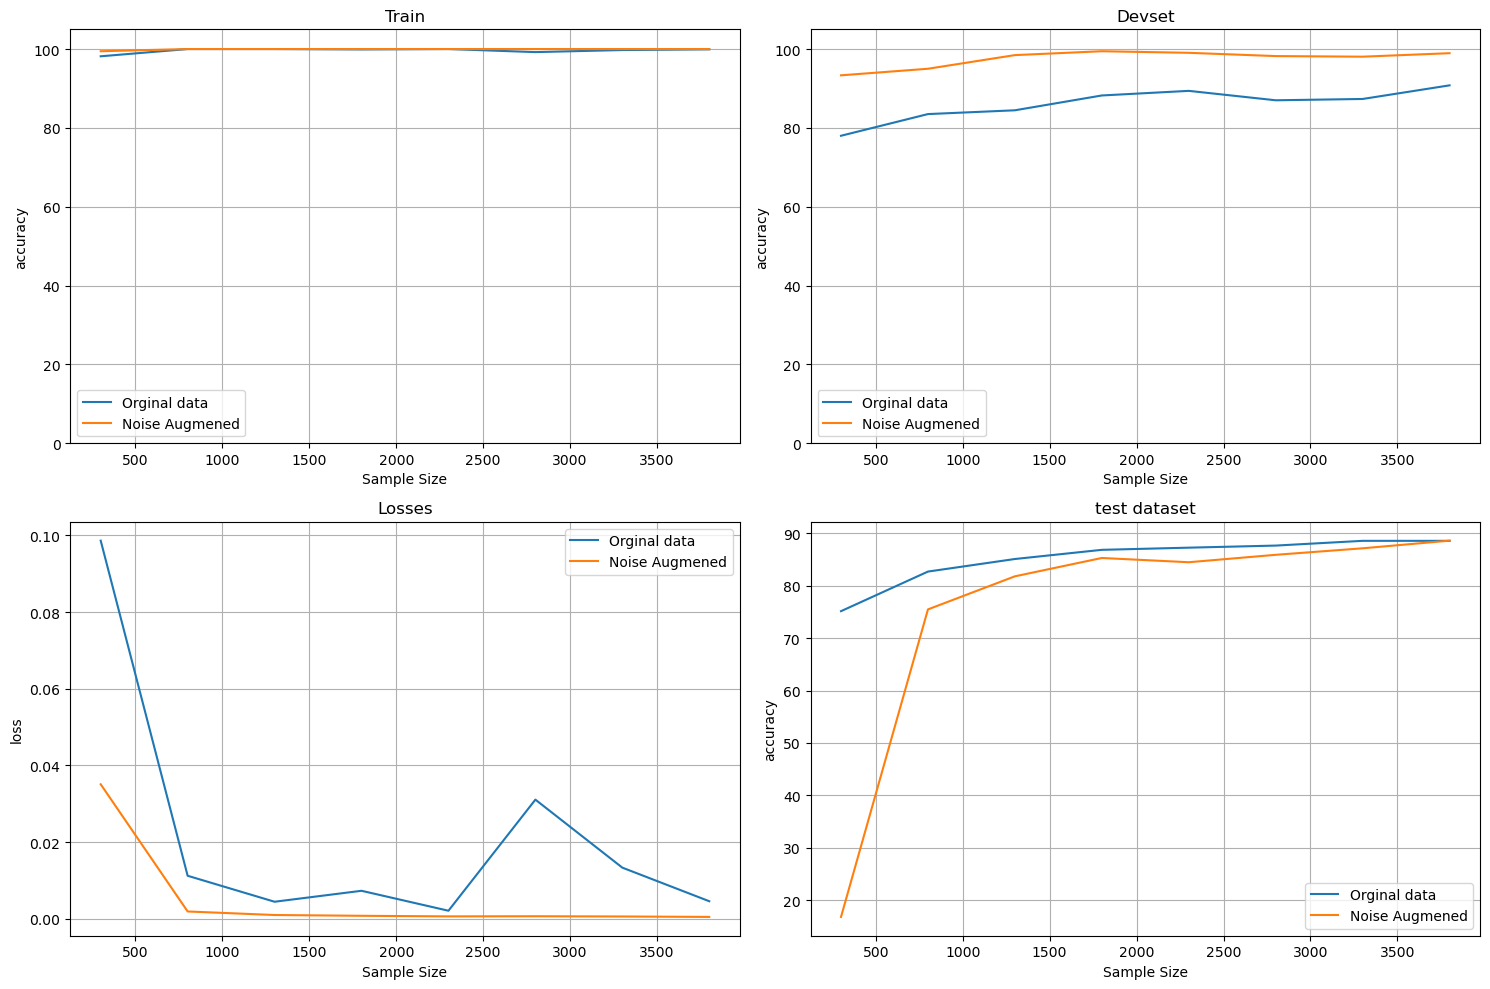

In [200]:
fig,axs=plt.subplots(2,2,figsize=(15,10))

titles=['Train','Devset','Losses','test dataset']
yAxLabel=['accuracy','accuracy','loss','accuracy']

for i,ax in enumerate(axs.flatten()):
    ax.plot(sampleSize,resultsSingleData[:,i],label='Orginal data')
    ax.plot(sampleSize,resultsDoubleData[:,i],label='Noise Augmened')
    print(i)
    ax.set_title(titles[i])
    ax.set_ylabel(yAxLabel[i])
    ax.legend()
    ax.set_xlabel('Sample Size')
    ax.grid()
    
    if i<2:
        ax.set_ylim([0,105])
        
plt.tight_layout()
plt.show()